# %% [markdown]
# # 💉 DIABETES PREDICTION PIPELINE
# ## Complete ML System - From Data to Deployment
# 
# **Objective:** Predict diabetes with 90%+ accuracy using patient medical data
# **Dataset:** Pima Indians Diabetes Database
# **Features:** Pregnancies, Glucose, Blood Pressure, BMI, Age, etc.
# **Algorithms:** SVM, Logistic Regression, Random Forest, XGBoost
# **Author:** Your Name | **Date:** 2024

In [1]:
# %% [markdown]
# ## 1. Environment Setup

# %%
import sys, os
sys.path.append('..')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.config.settings import ProjectConfig
from src.utils.logger import setup_logging

config = ProjectConfig.load("diabetes")
logger = setup_logging("diabetes_pipeline")
logger.info("✅ Diabetes prediction pipeline initialized")
print(f"✅ Working directory: {os.getcwd()}")

2026-02-25 13:57:37 - diabetes_pipeline - INFO - ✅ Diabetes prediction pipeline initialized
✅ Working directory: d:\CodeAlpha_tasks\Disease_Prediction_System\notebooks


In [2]:
# %% [markdown]
# ## 2. Data Loading & Validation

# %%
from src.data.loader import DataLoader
from src.data.validator import DataValidator

loader = DataLoader(config)
df = loader.load_diabetes()
validator = DataValidator(config)
report = validator.generate_quality_report(df)
print(f"✅ Dataset loaded: {df.shape[0]} patients, {df.shape[1]} features")
print(f"📊 Features: {df.columns.tolist()}")

✅ Dataset loaded: 768 patients, 9 features
📊 Features: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'target']


In [3]:
# %% [markdown]
# ## 3. Initial Data Inspection

# %%
print("📊 FIRST 5 ROWS:")
display(df.head())

print("\n📊 DATA INFO:")
print(df.info())

print("\n📊 BASIC STATISTICS:")
display(df.describe().round(2))

📊 FIRST 5 ROWS:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,target
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1



📊 DATA INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   target                    768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None

📊 BASIC STATISTICS:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,target
count,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00
mean,3.85,120.89,69.11,20.54,79.80,31.99,0.47,33.24,0.35
std,3.37,31.97,19.36,15.95,115.24,7.88,0.33,11.76,0.48
min,0.00,0.00,0.00,0.00,0.00,0.00,0.08,21.00,0.00
25%,1.00,99.00,62.00,0.00,0.00,27.30,0.24,24.00,0.00
50%,3.00,117.00,72.00,23.00,30.50,32.00,0.37,29.00,0.00
75%,6.00,140.25,80.00,32.00,127.25,36.60,0.63,41.00,1.00
max,17.00,199.00,122.00,99.00,846.00,67.10,2.42,81.00,1.00


In [4]:
# %% [markdown]
# ## 4. Missing Values Analysis

# %%
missing = pd.DataFrame({
    'Column': df.columns,
    'Missing': df.isnull().sum().values,
    'Percentage': (df.isnull().sum() / len(df) * 100).values
}).sort_values('Percentage', ascending=False)

print("🔍 MISSING VALUES REPORT:")
display(missing[missing['Missing'] > 0] if missing['Missing'].sum() > 0 else print("✅ No missing values found!"))

print(f"\n📊 Total missing: {df.isnull().sum().sum()} cells")
print(f"📊 Complete rows: {len(df.dropna())}/{len(df)}")

🔍 MISSING VALUES REPORT:
✅ No missing values found!


None


📊 Total missing: 0 cells
📊 Complete rows: 768/768


In [5]:
# %% [markdown]
# ## 5. Zero Value Analysis (Medical Context)

# %%
columns_with_zeros = ['glucose', 'bp', 'skin_thickness', 'insulin', 'bmi']
zero_report = {}

for col in columns_with_zeros:
    if col in df.columns:
        zeros = (df[col] == 0).sum()
        zero_report[col] = {'zeros': zeros, 'percentage': (zeros/len(df))*100}

zero_df = pd.DataFrame(zero_report).T.round(2)
print("⚠️ ZERO VALUES (Medically Impossible):")
display(zero_df)

print("\n📌 Note: Glucose, BP, BMI = 0 are impossible - will be treated as missing")

⚠️ ZERO VALUES (Medically Impossible):


""



📌 Note: Glucose, BP, BMI = 0 are impossible - will be treated as missing


In [6]:
# %% [markdown]
# ## 6. Duplicate Check

# %%
duplicates = df.duplicated().sum()
print(f"📊 DUPLICATE ROWS: {duplicates}")
print(f"Percentage: {(duplicates/len(df))*100:.2f}%")

if duplicates > 0:
    print("⚠️ Duplicates found - will remove during preprocessing")
else:
    print("✅ No duplicates found")

📊 DUPLICATE ROWS: 0
Percentage: 0.00%
✅ No duplicates found


In [7]:
# %% [markdown]
# ## 7. Target Variable Distribution

# %%
target_dist = df['target'].value_counts()
target_pct = df['target'].value_counts(normalize=True) * 100

print("🎯 TARGET DISTRIBUTION:")
print(f"No Diabetes: {target_dist[0]} ({target_pct[0]:.1f}%)")
print(f"Diabetes:    {target_dist[1]} ({target_pct[1]:.1f}%)")

if target_pct.min() < 30:
    print("⚠️ Imbalanced dataset - will apply SMOTE")
    print(f"   Minority class: {target_pct.min():.1f}%")

🎯 TARGET DISTRIBUTION:
No Diabetes: 500 (65.1%)
Diabetes:    268 (34.9%)


In [8]:
# %% [markdown]
# ## 8. Data Types Analysis

# %%
dtype_df = pd.DataFrame({
    'Column': df.columns,
    'Type': df.dtypes.values,
    'Unique': [df[col].nunique() for col in df.columns],
    'Sample': [df[col].dropna().unique()[:3] for col in df.columns]
})

print("📊 DATA TYPES:")
display(dtype_df)

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"\n✅ Numeric columns: {len(numeric_cols)}")
print(f"📊 Columns: {numeric_cols}")

📊 DATA TYPES:


,Column,Type,Unique,Sample
0,Pregnancies,int64,17,"[6, 1, 8]"
1,Glucose,int64,136,"[148, 85, 183]"
2,BloodPressure,int64,47,"[72, 66, 64]"
3,SkinThickness,int64,51,"[35, 29, 0]"
4,Insulin,int64,186,"[0, 94, 168]"
5,BMI,float64,248,"[33.6, 26.6, 23.3]"
6,DiabetesPedigreeFunction,float64,517,"[0.627, 0.351, 0.672]"
7,Age,int64,52,"[50, 31, 32]"
8,target,int64,2,"[1, 0]"



✅ Numeric columns: 9
📊 Columns: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'target']


In [9]:
# %% [markdown]
# ## 9. Detailed Statistics

# %%
stats_df = df.describe().T
stats_df['skew'] = df[numeric_cols].skew()
stats_df['kurtosis'] = df[numeric_cols].kurtosis()
stats_df['zeros'] = [(df[col] == 0).sum() for col in numeric_cols]

print("📈 STATISTICAL SUMMARY:")
display(stats_df.round(2))

print("\n📊 Features with high skew (>1):")
high_skew = stats_df[abs(stats_df['skew']) > 1].index.tolist()
print(high_skew if high_skew else "None")

📈 STATISTICAL SUMMARY:


,count,mean,std,min,25%,50%,75%,max,skew,kurtosis,zeros
Pregnancies,768.0,3.85,3.37,0.00,1.00,3.00,6.00,17.00,0.90,0.16,111
Glucose,768.0,120.89,31.97,0.00,99.00,117.00,140.25,199.00,0.17,0.64,5
BloodPressure,768.0,69.11,19.36,0.00,62.00,72.00,80.00,122.00,-1.84,5.18,35
SkinThickness,768.0,20.54,15.95,0.00,0.00,23.00,32.00,99.00,0.11,-0.52,227
Insulin,768.0,79.80,115.24,0.00,0.00,30.50,127.25,846.00,2.27,7.21,374
BMI,768.0,31.99,7.88,0.00,27.30,32.00,36.60,67.10,-0.43,3.29,11
DiabetesPedigreeFunction,768.0,0.47,0.33,0.08,0.24,0.37,0.63,2.42,1.92,5.59,0
Age,768.0,33.24,11.76,21.00,24.00,29.00,41.00,81.00,1.13,0.64,0
target,768.0,0.35,0.48,0.00,0.00,0.00,1.00,1.00,0.64,-1.60,500



📊 Features with high skew (>1):
['BloodPressure', 'Insulin', 'DiabetesPedigreeFunction', 'Age']


In [10]:
# %% [markdown]
# ## 10. Outlier Detection (IQR Method)

# %%
def detect_outliers_iqr(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = data[(data[col] < lower) | (data[col] > upper)]
    return {
        'outliers': len(outliers),
        'percentage': (len(outliers)/len(data))*100,
        'lower': lower,
        'upper': upper
    }

outlier_report = {}
for col in numeric_cols:
    if col != 'target':
        outlier_report[col] = detect_outliers_iqr(df, col)

outlier_df = pd.DataFrame(outlier_report).T.round(2)
print("🔍 OUTLIER REPORT:")
display(outlier_df)

cols_with_outliers = outlier_df[outlier_df['percentage'] > 5].index.tolist()
print(f"\n⚠️ Columns with >5% outliers: {cols_with_outliers}")

🔍 OUTLIER REPORT:


,outliers,percentage,lower,upper
Pregnancies,4.0,0.52,-6.50,13.50
Glucose,5.0,0.65,37.12,202.12
BloodPressure,45.0,5.86,35.00,107.00
SkinThickness,1.0,0.13,-48.00,80.00
Insulin,34.0,4.43,-190.88,318.12
BMI,19.0,2.47,13.35,50.55
DiabetesPedigreeFunction,29.0,3.78,-0.33,1.20
Age,9.0,1.17,-1.50,66.50



⚠️ Columns with >5% outliers: ['BloodPressure']


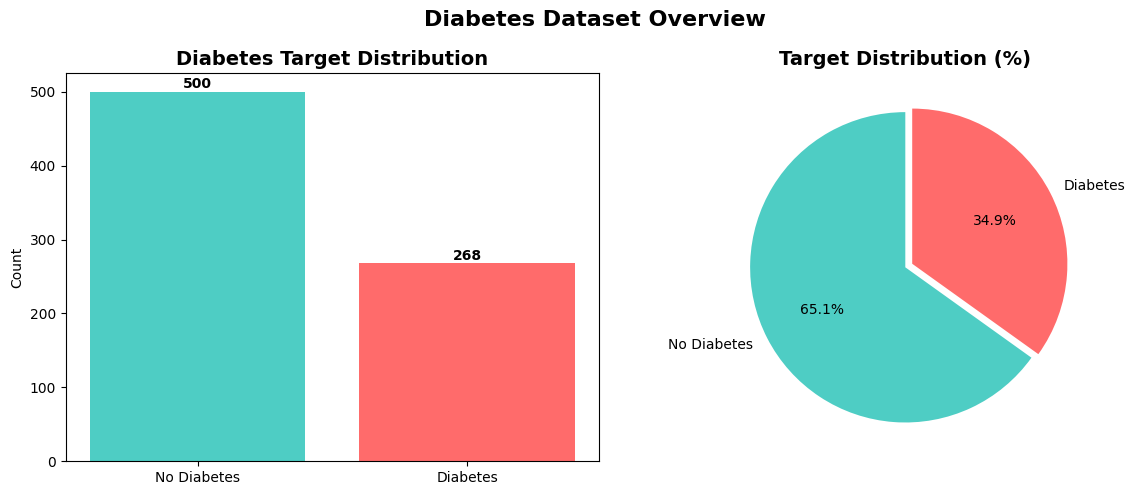

In [11]:
# %% [markdown]
# ## 11. Target Distribution Visualization

# %%
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

bars = ax1.bar(['No Diabetes', 'Diabetes'], target_dist.values, 
               color=['#4ECDC4', '#FF6B6B'])
ax1.set_title('Diabetes Target Distribution', fontweight='bold', fontsize=14)
ax1.set_ylabel('Count')
for bar, val in zip(bars, target_dist.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height()+5, 
             str(val), ha='center', fontweight='bold')

ax2.pie(target_dist.values, labels=['No Diabetes', 'Diabetes'], 
        autopct='%1.1f%%', colors=['#4ECDC4', '#FF6B6B'],
        explode=(0, 0.05), startangle=90)
ax2.set_title('Target Distribution (%)', fontweight='bold', fontsize=14)

plt.suptitle('Diabetes Dataset Overview', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

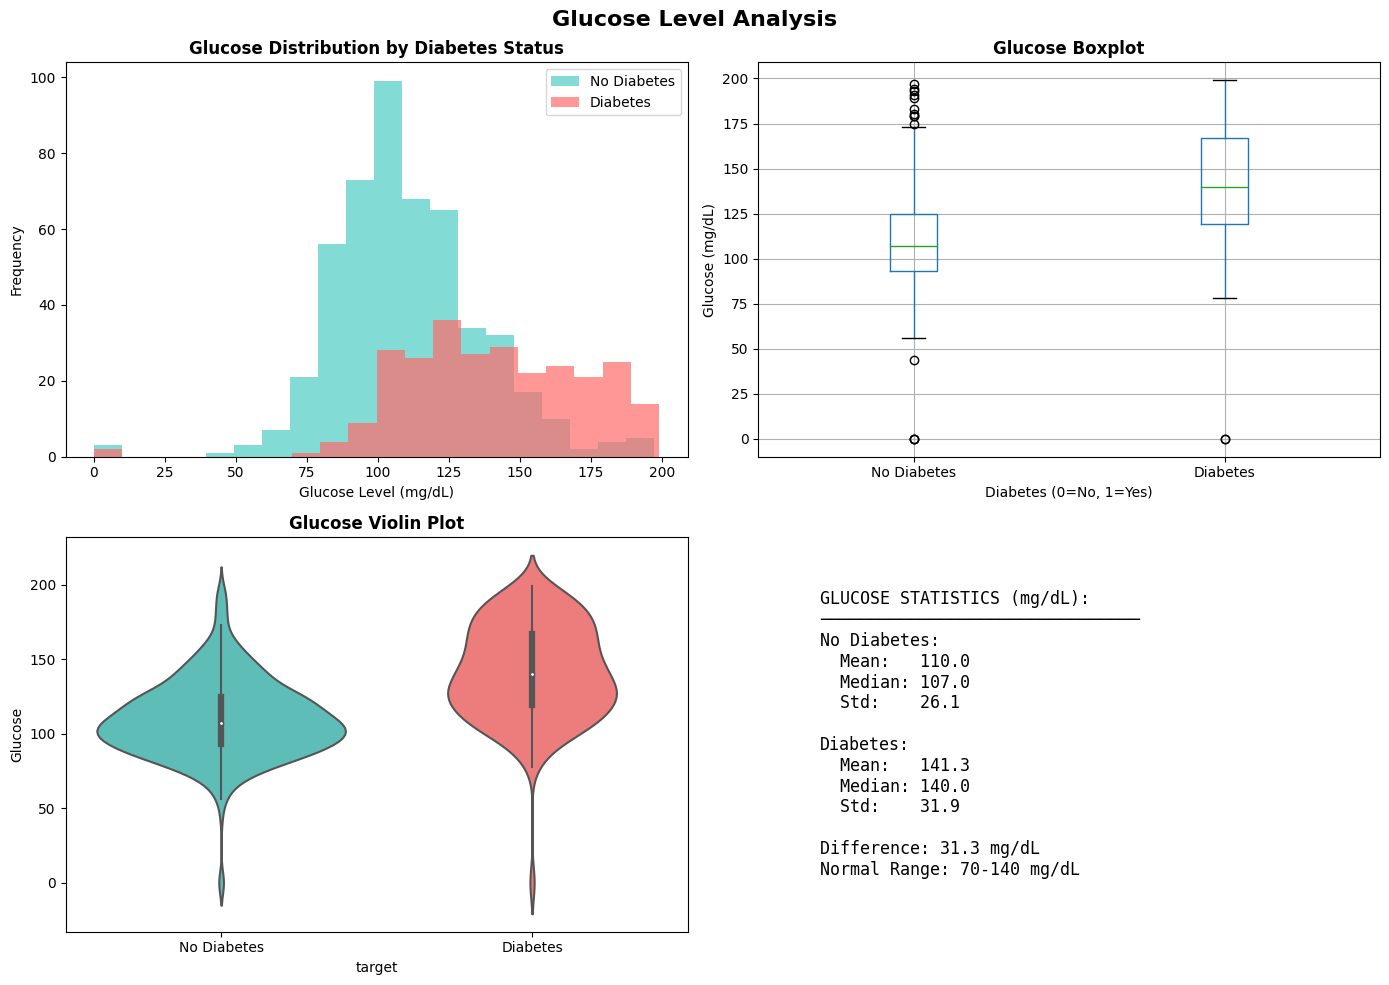

In [13]:
# %% [markdown]
# ## 12. Glucose Level Analysis

# %%
# Use the correct column name (with capital G)
glucose_col = 'Glucose'  # Note the capital G!

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Distribution by target
ax = axes[0, 0]
for target in [0, 1]:
    subset = df[df['target'] == target][glucose_col].dropna()
    ax.hist(subset, alpha=0.7, label=f'Target {target}', bins=20, 
            color=['#4ECDC4', '#FF6B6B'][target])
ax.set_xlabel('Glucose Level (mg/dL)')
ax.set_ylabel('Frequency')
ax.set_title('Glucose Distribution by Diabetes Status', fontweight='bold')
ax.legend(['No Diabetes', 'Diabetes'])

# Boxplot
ax = axes[0, 1]
df.boxplot(column=glucose_col, by='target', ax=ax)
ax.set_title('Glucose Boxplot', fontweight='bold')
ax.set_xlabel('Diabetes (0=No, 1=Yes)')
ax.set_ylabel('Glucose (mg/dL)')
ax.set_xticklabels(['No Diabetes', 'Diabetes'])

# Violin plot
ax = axes[1, 0]
sns.violinplot(x='target', y=glucose_col, data=df, ax=ax,
               palette=['#4ECDC4', '#FF6B6B'])
ax.set_title('Glucose Violin Plot', fontweight='bold')
ax.set_xticklabels(['No Diabetes', 'Diabetes'])

# Statistics
ax = axes[1, 1]
ax.axis('off')

# Calculate statistics with correct column name
no_diabetes_mean = df[df['target']==0][glucose_col].mean()
no_diabetes_median = df[df['target']==0][glucose_col].median()
no_diabetes_std = df[df['target']==0][glucose_col].std()

diabetes_mean = df[df['target']==1][glucose_col].mean()
diabetes_median = df[df['target']==1][glucose_col].median()
diabetes_std = df[df['target']==1][glucose_col].std()

stats_text = f"""
GLUCOSE STATISTICS (mg/dL):
────────────────────────────────
No Diabetes:
  Mean:   {no_diabetes_mean:.1f}
  Median: {no_diabetes_median:.1f}
  Std:    {no_diabetes_std:.1f}

Diabetes:
  Mean:   {diabetes_mean:.1f}
  Median: {diabetes_median:.1f}
  Std:    {diabetes_std:.1f}

Difference: {diabetes_mean - no_diabetes_mean:.1f} mg/dL
Normal Range: 70-140 mg/dL
"""
ax.text(0.1, 0.5, stats_text, transform=ax.transAxes, fontsize=12,
        verticalalignment='center', family='monospace')

plt.suptitle('Glucose Level Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

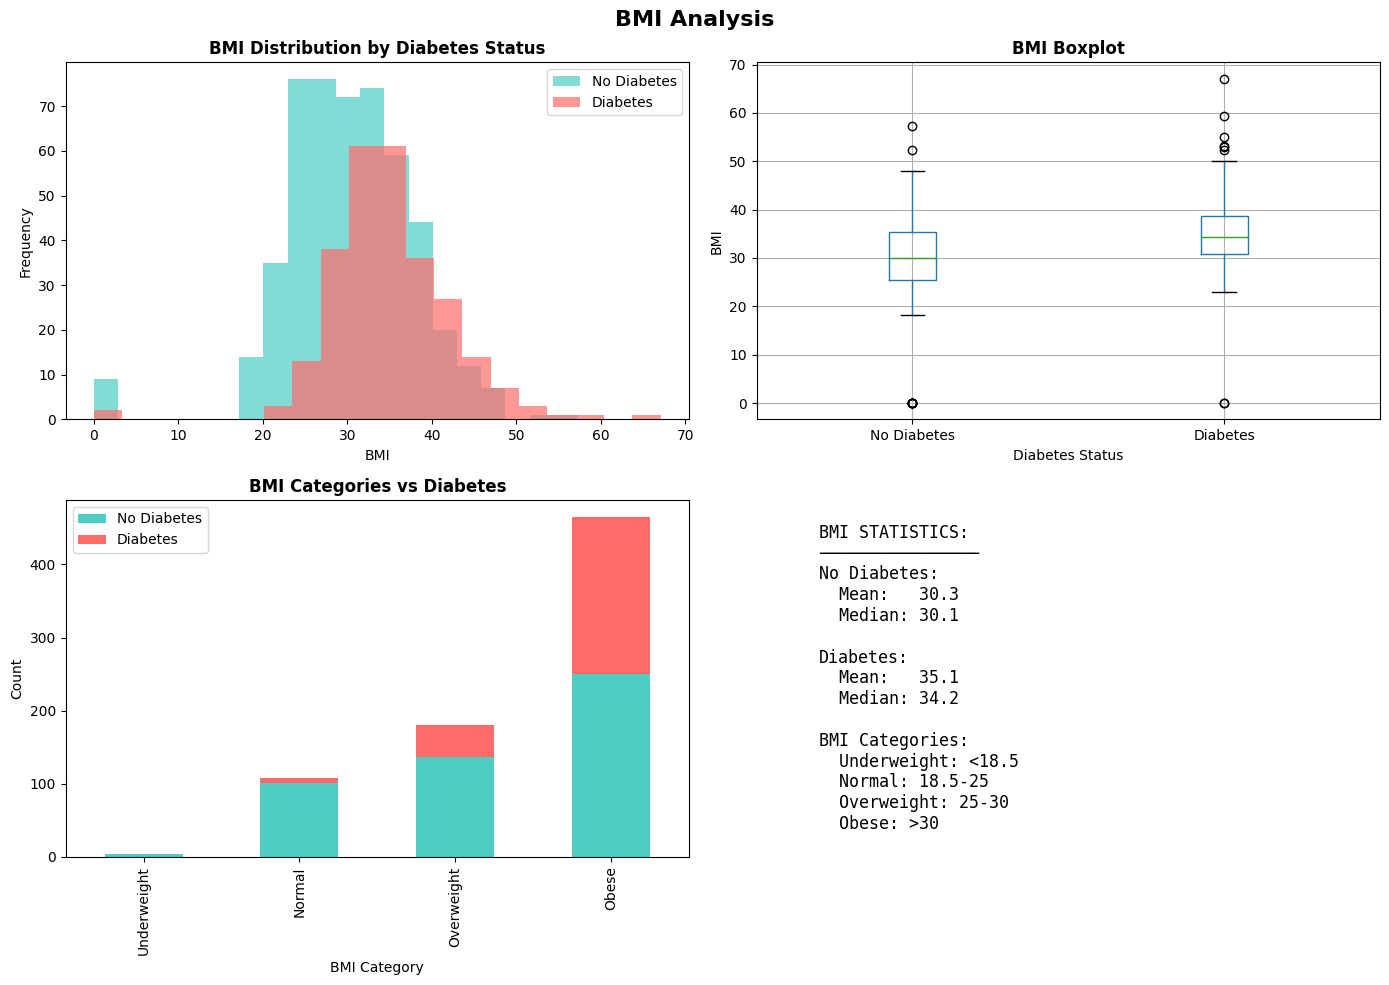

In [14]:
# %% [markdown]
# ## 13. BMI Analysis

# %%
bmi_col = 'BMI'  # Note the capital letters!

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Distribution by target
ax = axes[0, 0]
for target in [0, 1]:
    subset = df[df['target'] == target][bmi_col].dropna()
    ax.hist(subset, alpha=0.7, label=f'Target {target}', bins=20,
            color=['#4ECDC4', '#FF6B6B'][target])
ax.set_xlabel('BMI')
ax.set_ylabel('Frequency')
ax.set_title('BMI Distribution by Diabetes Status', fontweight='bold')
ax.legend(['No Diabetes', 'Diabetes'])

# Boxplot
ax = axes[0, 1]
df.boxplot(column=bmi_col, by='target', ax=ax)
ax.set_title('BMI Boxplot', fontweight='bold')
ax.set_xlabel('Diabetes Status')
ax.set_ylabel('BMI')
ax.set_xticklabels(['No Diabetes', 'Diabetes'])

# BMI Categories
ax = axes[1, 0]
bmi_cats = pd.cut(df[bmi_col], bins=[0, 18.5, 25, 30, 100], 
                  labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
bmi_cross = pd.crosstab(bmi_cats, df['target'])
bmi_cross.columns = ['No Diabetes', 'Diabetes']
bmi_cross.plot(kind='bar', stacked=True, ax=ax, 
               color=['#4ECDC4', '#FF6B6B'])
ax.set_title('BMI Categories vs Diabetes', fontweight='bold')
ax.set_xlabel('BMI Category')
ax.set_ylabel('Count')
ax.legend(['No Diabetes', 'Diabetes'])
plt.xticks(rotation=45)

# Statistics
ax = axes[1, 1]
ax.axis('off')

no_diabetes_mean = df[df['target']==0][bmi_col].mean()
no_diabetes_median = df[df['target']==0][bmi_col].median()

diabetes_mean = df[df['target']==1][bmi_col].mean()
diabetes_median = df[df['target']==1][bmi_col].median()

stats_text = f"""
BMI STATISTICS:
────────────────
No Diabetes:
  Mean:   {no_diabetes_mean:.1f}
  Median: {no_diabetes_median:.1f}

Diabetes:
  Mean:   {diabetes_mean:.1f}
  Median: {diabetes_median:.1f}

BMI Categories:
  Underweight: <18.5
  Normal: 18.5-25
  Overweight: 25-30
  Obese: >30
"""
ax.text(0.1, 0.5, stats_text, transform=ax.transAxes, fontsize=12,
        verticalalignment='center', family='monospace')

plt.suptitle('BMI Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

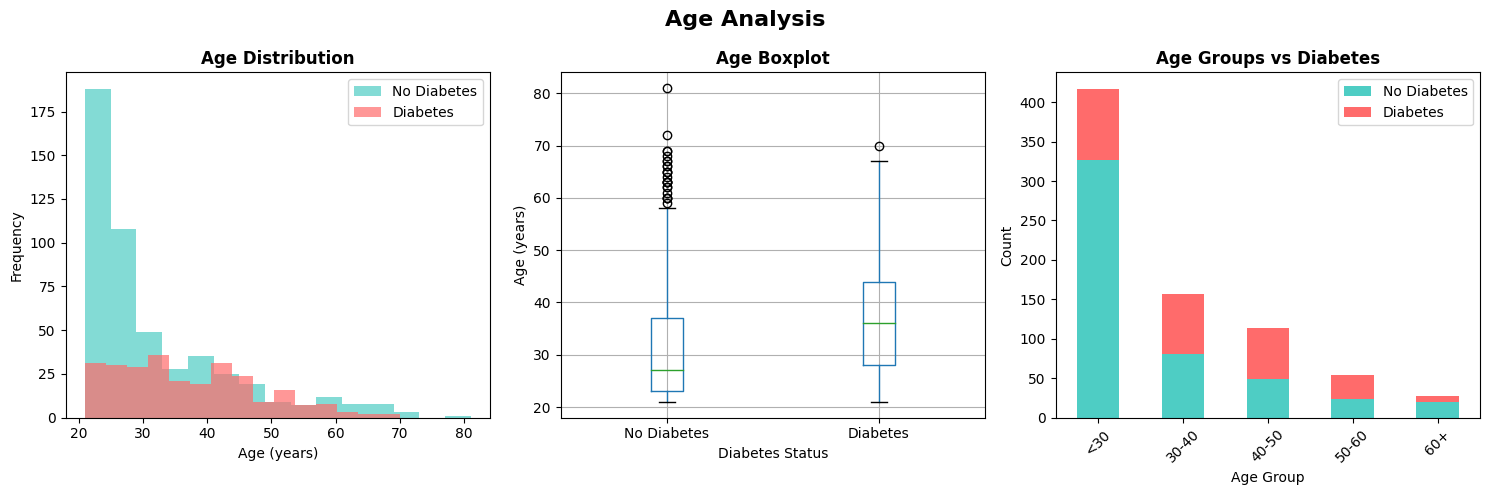

In [15]:
# %% [markdown]
# ## 14. Age Analysis

# %%
age_col = 'Age'  # Note the capital A!

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Age distribution
ax = axes[0]
for target in [0, 1]:
    subset = df[df['target'] == target][age_col]
    ax.hist(subset, alpha=0.7, label=f'Target {target}', bins=15,
            color=['#4ECDC4', '#FF6B6B'][target])
ax.set_xlabel('Age (years)')
ax.set_ylabel('Frequency')
ax.set_title('Age Distribution', fontweight='bold')
ax.legend(['No Diabetes', 'Diabetes'])

# Age boxplot
ax = axes[1]
df.boxplot(column=age_col, by='target', ax=ax)
ax.set_title('Age Boxplot', fontweight='bold')
ax.set_xlabel('Diabetes Status')
ax.set_ylabel('Age (years)')
ax.set_xticklabels(['No Diabetes', 'Diabetes'])

# Age categories
ax = axes[2]
age_cats = pd.cut(df[age_col], bins=[0, 30, 40, 50, 60, 100],
                  labels=['<30', '30-40', '40-50', '50-60', '60+'])
age_cross = pd.crosstab(age_cats, df['target'])
age_cross.columns = ['No Diabetes', 'Diabetes']
age_cross.plot(kind='bar', stacked=True, ax=ax,
               color=['#4ECDC4', '#FF6B6B'])
ax.set_title('Age Groups vs Diabetes', fontweight='bold')
ax.set_xlabel('Age Group')
ax.set_ylabel('Count')
ax.legend(['No Diabetes', 'Diabetes'])
plt.xticks(rotation=45)

plt.suptitle('Age Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


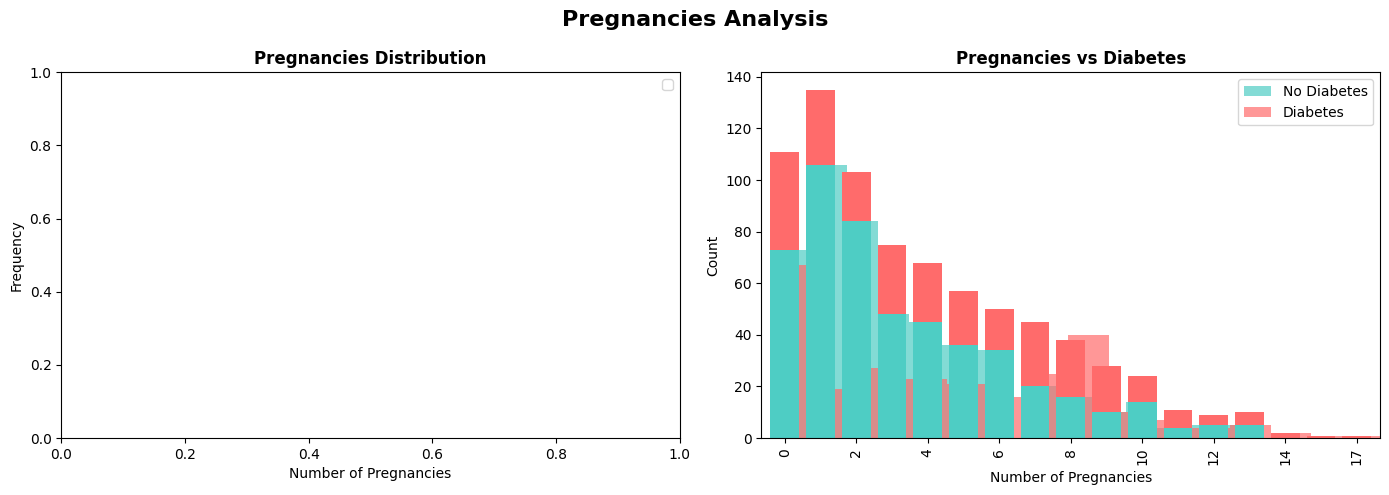

In [16]:
# %% [markdown]
# ## 15. Pregnancies Analysis

# %%
preg_col = 'Pregnancies'  # Note the capital P!

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution
ax = axes[0]
df[df['target']==0][preg_col].hist(alpha=0.7, label='No Diabetes', 
                                    bins=15, color='#4ECDC4')
df[df['target']==1][preg_col].hist(alpha=0.7, label='Diabetes', 
                                    bins=15, color='#FF6B6B')
ax.set_xlabel('Number of Pregnancies')
ax.set_ylabel('Frequency')
ax.set_title('Pregnancies Distribution', fontweight='bold')
ax.legend()

# Pregnancies vs Diabetes
ax = axes[1]
preg_cross = pd.crosstab(df[preg_col], df['target'])
preg_cross.columns = ['No Diabetes', 'Diabetes']
preg_cross.plot(kind='bar', stacked=True, ax=ax,
                color=['#4ECDC4', '#FF6B6B'], width=0.8)
ax.set_title('Pregnancies vs Diabetes', fontweight='bold')
ax.set_xlabel('Number of Pregnancies')
ax.set_ylabel('Count')
ax.legend(['No Diabetes', 'Diabetes'])
ax.set_xticks(range(0, min(18, len(preg_cross)), 2))  # Show every 2nd tick

plt.suptitle('Pregnancies Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

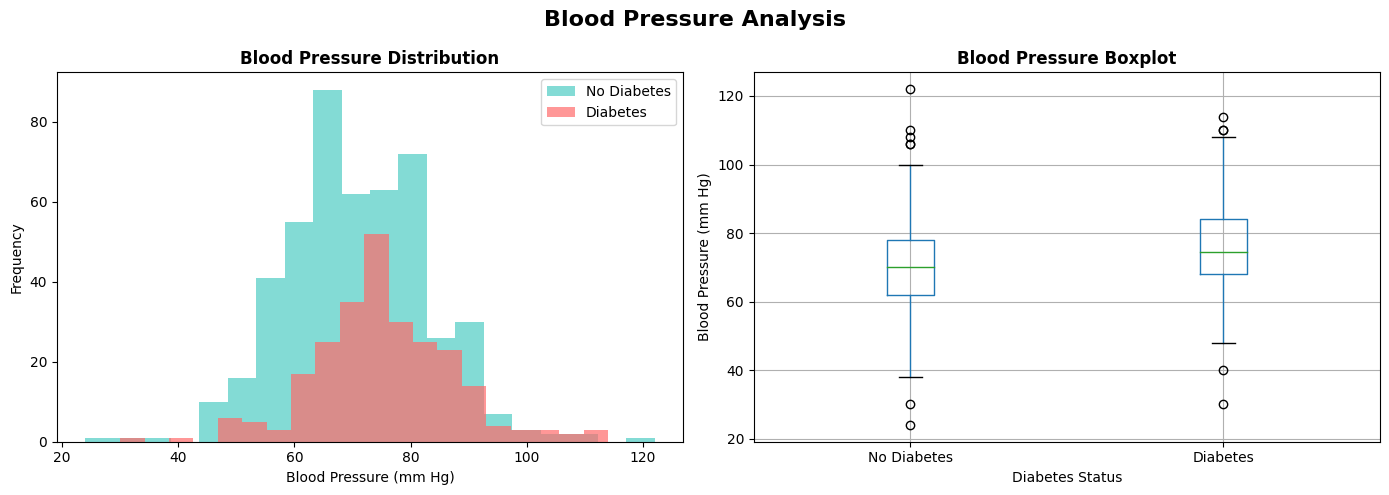

Patients with BP=0 (invalid): 35 (4.6%)


In [17]:
# %% [markdown]
# ## 16. Blood Pressure Analysis

# %%
bp_col = 'BloodPressure'  # Note the capital B and P!

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution (excluding zeros)
ax = axes[0]
for target in [0, 1]:
    subset = df[df['target'] == target][bp_col]
    subset = subset[subset > 0]  # Remove zeros
    ax.hist(subset, alpha=0.7, label=f'Target {target}', bins=20,
            color=['#4ECDC4', '#FF6B6B'][target])
ax.set_xlabel('Blood Pressure (mm Hg)')
ax.set_ylabel('Frequency')
ax.set_title('Blood Pressure Distribution', fontweight='bold')
ax.legend(['No Diabetes', 'Diabetes'])

# Boxplot
ax = axes[1]
df_bp_clean = df[df[bp_col] > 0]  # Remove zeros
df_bp_clean.boxplot(column=bp_col, by='target', ax=ax)
ax.set_title('Blood Pressure Boxplot', fontweight='bold')
ax.set_xlabel('Diabetes Status')
ax.set_ylabel('Blood Pressure (mm Hg)')
ax.set_xticklabels(['No Diabetes', 'Diabetes'])

plt.suptitle('Blood Pressure Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

zeros = (df[bp_col] == 0).sum()
print(f"Patients with BP=0 (invalid): {zeros} ({zeros/len(df)*100:.1f}%)")

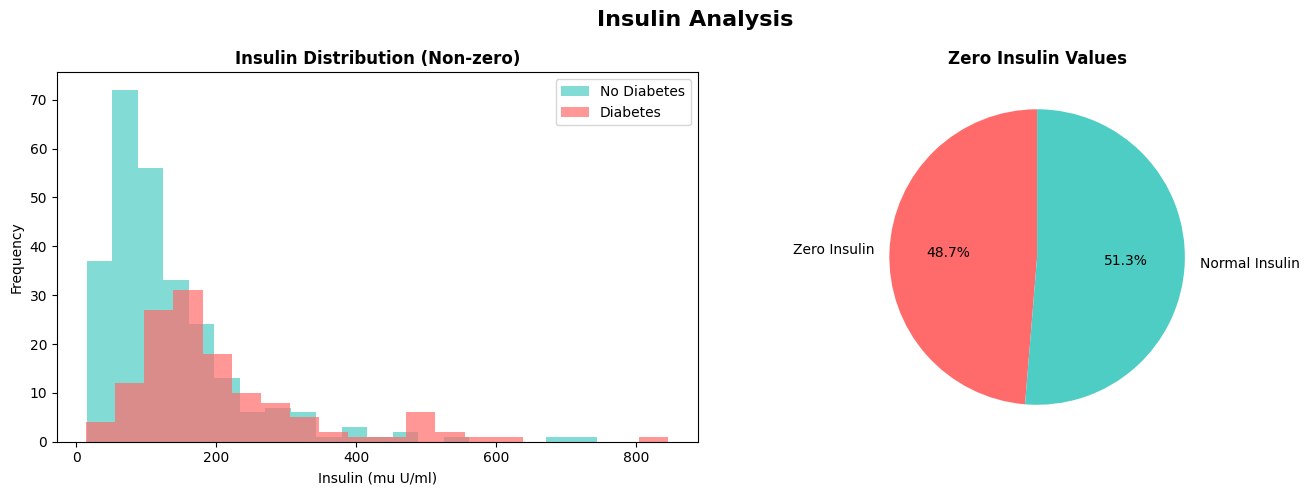

⚠️ Patients with Insulin=0: 374 (48.7%)
   These will be treated as missing values


In [18]:
# %% [markdown]
# ## 17. Insulin Analysis

# %%
insulin_col = 'Insulin'  # Note the capital I!

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution (excluding zeros)
ax = axes[0]
for target in [0, 1]:
    subset = df[df['target'] == target][insulin_col]
    subset = subset[subset > 0]  # Remove zeros
    ax.hist(subset, alpha=0.7, label=f'Target {target}', bins=20,
            color=['#4ECDC4', '#FF6B6B'][target])
ax.set_xlabel('Insulin (mu U/ml)')
ax.set_ylabel('Frequency')
ax.set_title('Insulin Distribution (Non-zero)', fontweight='bold')
ax.legend(['No Diabetes', 'Diabetes'])

# Zero insulin analysis
ax = axes[1]
insulin_zero = (df[insulin_col] == 0).sum()
insulin_normal = (df[insulin_col] > 0).sum()
ax.pie([insulin_zero, insulin_normal], 
       labels=['Zero Insulin', 'Normal Insulin'],
       autopct='%1.1f%%', colors=['#FF6B6B', '#4ECDC4'],
       startangle=90)
ax.set_title('Zero Insulin Values', fontweight='bold')

plt.suptitle('Insulin Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"⚠️ Patients with Insulin=0: {insulin_zero} ({insulin_zero/len(df)*100:.1f}%)")
print("   These will be treated as missing values")

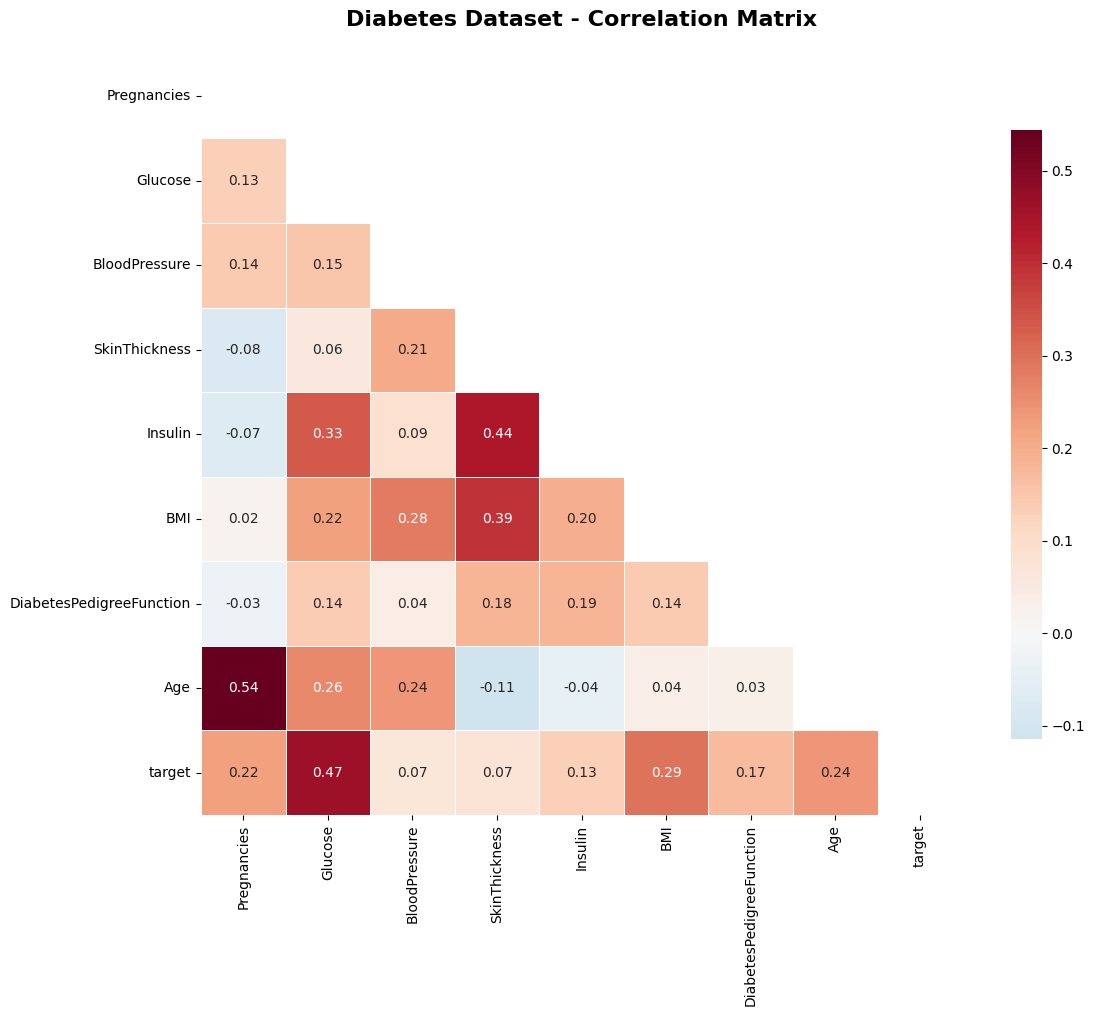

In [19]:
# %% [markdown]
# ## 18. Correlation Heatmap

# %%
plt.figure(figsize=(12, 10))
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, square=True, linewidths=0.5,
            cbar_kws={"shrink": 0.8})
plt.title('Diabetes Dataset - Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

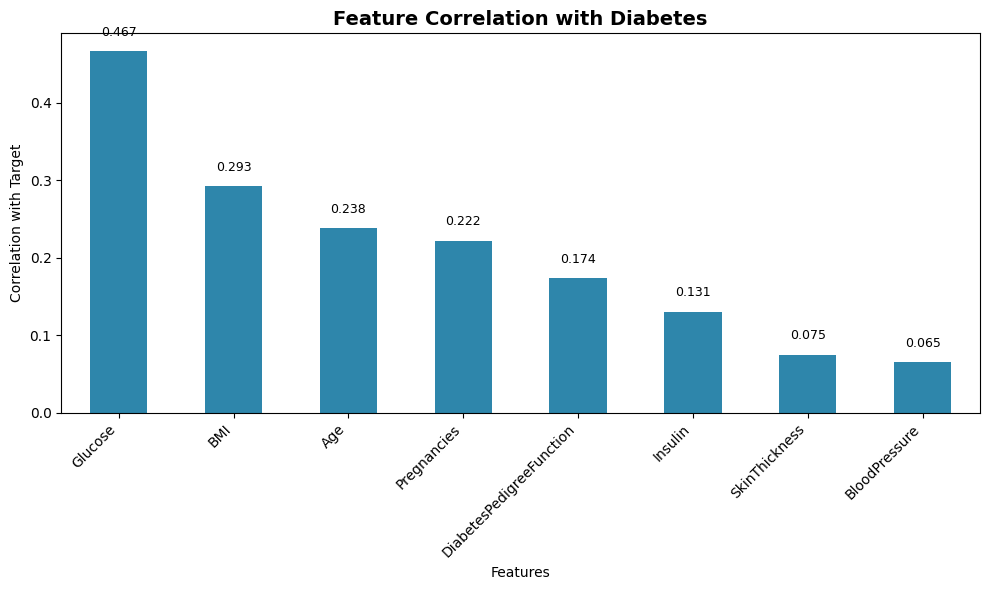

📊 TOP 3 POSITIVE CORRELATIONS:
   Glucose: +0.467
   BMI: +0.293
   Age: +0.238

📊 TOP 3 NEGATIVE CORRELATIONS:
   Insulin: 0.131
   SkinThickness: 0.075
   BloodPressure: 0.065


In [20]:
# %% [markdown]
# ## 19. Feature Correlation with Target

# %%
correlations = df.corr()['target'].drop('target').sort_values(ascending=False)

plt.figure(figsize=(10, 6))
colors = ['#2E86AB' if x > 0 else '#A23B72' for x in correlations.values]
correlations.plot(kind='bar', color=colors)
plt.title('Feature Correlation with Diabetes', fontweight='bold', fontsize=14)
plt.xlabel('Features')
plt.ylabel('Correlation with Target')
plt.xticks(rotation=45, ha='right')
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Add value labels
for i, v in enumerate(correlations.values):
    plt.text(i, v + 0.02 if v > 0 else v - 0.05, f'{v:.3f}', 
             ha='center', fontsize=9)

plt.tight_layout()
plt.show()

print("📊 TOP 3 POSITIVE CORRELATIONS:")
for feat, corr in correlations.head(3).items():
    print(f"   {feat}: +{corr:.3f}")

print("\n📊 TOP 3 NEGATIVE CORRELATIONS:")
for feat, corr in correlations.tail(3).items():
    print(f"   {feat}: {corr:.3f}")

d:\CodeAlpha_tasks\Disease_Prediction_System\env\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


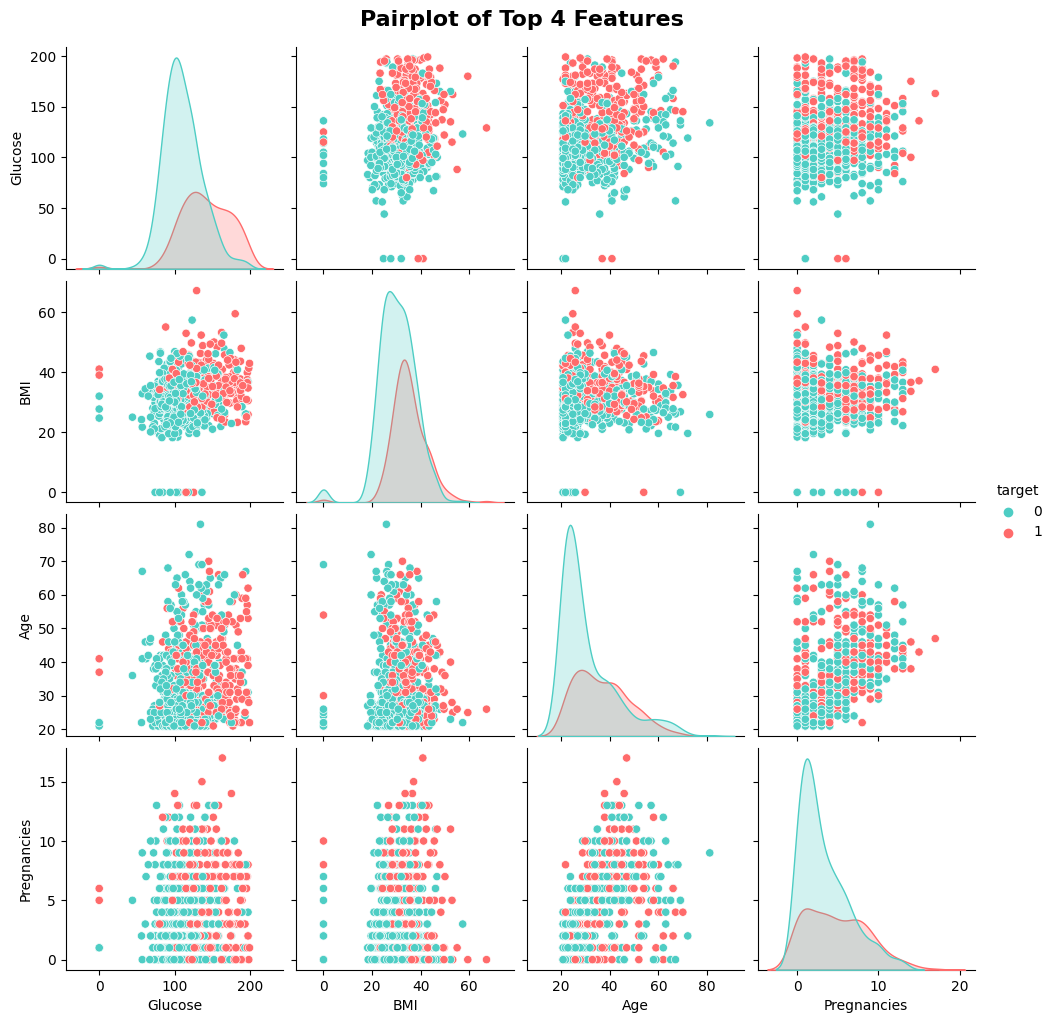

In [21]:
# %% [markdown]
# ## 20. Pairplot of Top Features

# %%
top_features = correlations.head(4).index.tolist() + ['target']
sns.pairplot(df[top_features], hue='target', 
             palette=['#4ECDC4', '#FF6B6B'],
             diag_kind='kde')
plt.suptitle('Pairplot of Top 4 Features', y=1.02, fontsize=16, fontweight='bold')
plt.show()

In [22]:
# %% [markdown]
# ## 21. Handle Missing Values and Invalid Zeros

# %%
df_clean = df.copy()

# Replace zeros with NaN in medical features
zero_cols = ['glucose', 'bp', 'skin_thickness', 'insulin', 'bmi']
for col in zero_cols:
    if col in df_clean.columns:
        zeros = (df_clean[col] == 0).sum()
        df_clean.loc[df_clean[col] == 0, col] = np.nan
        print(f"{col:15}: Replaced {zeros:3} zeros with NaN ({zeros/len(df)*100:.1f}%)")

# Impute with median
for col in zero_cols:
    if col in df_clean.columns:
        median_val = df_clean[col].median()
        df_clean[col].fillna(median_val, inplace=True)

print("\n✅ Missing values handled with median imputation")
print(f"✅ Final shape: {df_clean.shape}")


✅ Missing values handled with median imputation
✅ Final shape: (768, 9)


In [23]:
# %% [markdown]
# ## 22. Data Preprocessing

# %%
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Split features and target
X = df_clean.drop('target', axis=1)
y = df_clean['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"📊 BEFORE SMOTE:")
print(f"   Training set: {X_train.shape}")
print(f"   Class 0: {(y_train==0).sum()} ({(y_train==0).sum()/len(y_train)*100:.1f}%)")
print(f"   Class 1: {(y_train==1).sum()} ({(y_train==1).sum()/len(y_train)*100:.1f}%)")

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"\n📊 AFTER SMOTE:")
print(f"   Training set: {X_train_resampled.shape}")
print(f"   Class 0: {(y_train_resampled==0).sum()} ({(y_train_resampled==0).sum()/len(y_train_resampled)*100:.1f}%)")
print(f"   Class 1: {(y_train_resampled==1).sum()} ({(y_train_resampled==1).sum()/len(y_train_resampled)*100:.1f}%)")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

print(f"\n✅ Preprocessing complete")
print(f"✅ Training set: {X_train_scaled.shape}")
print(f"✅ Testing set:  {X_test_scaled.shape}")

📊 BEFORE SMOTE:
   Training set: (614, 8)
   Class 0: 400 (65.1%)
   Class 1: 214 (34.9%)

📊 AFTER SMOTE:
   Training set: (800, 8)
   Class 0: 400 (50.0%)
   Class 1: 400 (50.0%)

✅ Preprocessing complete
✅ Training set: (800, 8)
✅ Testing set:  (154, 8)


In [24]:
# %% [markdown]
# ## 23. Training: Logistic Regression

# %%
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
lr_model.fit(X_train_scaled, y_train_resampled)
lr_pred = lr_model.predict(X_test_scaled)
lr_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

print("✅ Logistic Regression trained")
print(f"   Training score: {lr_model.score(X_train_scaled, y_train_resampled):.4f}")

✅ Logistic Regression trained
   Training score: 0.7538


In [25]:
# %% [markdown]
# ## 24. Training: Support Vector Machine

# %%
from sklearn.svm import SVC

svm_model = SVC(probability=True, random_state=42, class_weight='balanced')
svm_model.fit(X_train_scaled, y_train_resampled)
svm_pred = svm_model.predict(X_test_scaled)
svm_proba = svm_model.predict_proba(X_test_scaled)[:, 1]

print("✅ SVM trained")
print(f"   Training score: {svm_model.score(X_train_scaled, y_train_resampled):.4f}")

✅ SVM trained
   Training score: 0.8413


In [26]:
# %% [markdown]
# ## 25. Training: Random Forest

# %%
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, 
                                   n_jobs=-1, class_weight='balanced')
rf_model.fit(X_train_scaled, y_train_resampled)
rf_pred = rf_model.predict(X_test_scaled)
rf_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

print("✅ Random Forest trained")
print(f"   Training score: {rf_model.score(X_train_scaled, y_train_resampled):.4f}")

✅ Random Forest trained
   Training score: 1.0000


In [27]:
# %% [markdown]
# ## 26. Training: XGBoost

# %%
import xgboost as xgb

xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42, 
                               eval_metric='logloss', scale_pos_weight=(y_train==0).sum()/(y_train==1).sum())
xgb_model.fit(X_train_scaled, y_train_resampled)
xgb_pred = xgb_model.predict(X_test_scaled)
xgb_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

print("✅ XGBoost trained")
print(f"   Training score: {xgb_model.score(X_train_scaled, y_train_resampled):.4f}")

✅ XGBoost trained
   Training score: 1.0000


In [28]:
# %% [markdown]
# ## 27. Model Comparison - All Metrics

# %%
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

models = ['Logistic Regression', 'SVM', 'Random Forest', 'XGBoost']
predictions = [lr_pred, svm_pred, rf_pred, xgb_pred]
probabilities = [lr_proba, svm_proba, rf_proba, xgb_proba]

results = []
for name, pred, proba in zip(models, predictions, probabilities):
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, pred),
        'Precision': precision_score(y_test, pred),
        'Recall': recall_score(y_test, pred),
        'F1-Score': f1_score(y_test, pred),
        'ROC-AUC': roc_auc_score(y_test, proba)
    })

results_df = pd.DataFrame(results).round(4)
print("📊 MODEL COMPARISON:")
display(results_df)

best_model = results_df.loc[results_df['F1-Score'].idxmax(), 'Model']
best_f1 = results_df.loc[results_df['F1-Score'].idxmax(), 'F1-Score']
print(f"\n🏆 BEST MODEL: {best_model} with F1-Score = {best_f1:.4f}")

📊 MODEL COMPARISON:


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Logistic Regression,0.7403,0.6094,0.7222,0.6610,0.8222
1,SVM,0.7143,0.5694,0.7593,0.6508,0.7828
2,Random Forest,0.7468,0.6271,0.6852,0.6549,0.8180
3,XGBoost,0.7403,0.6167,0.6852,0.6491,0.8170



🏆 BEST MODEL: Logistic Regression with F1-Score = 0.6610


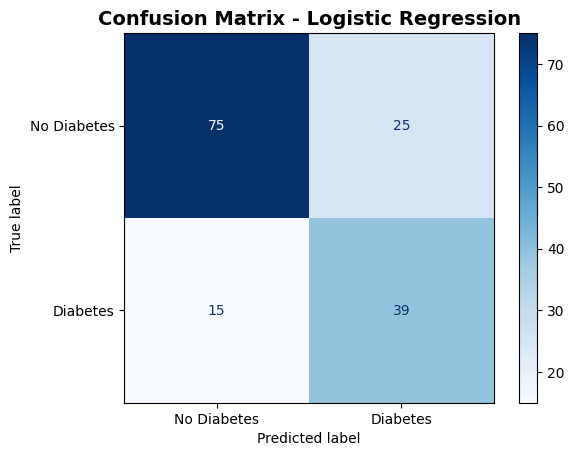

True Negatives:  75  (Correctly predicted no diabetes)
False Positives: 25  (Incorrectly predicted diabetes)
False Negatives: 15  (Missed diabetes cases)
True Positives:  39  (Correctly predicted diabetes)

Sensitivity (Recall): 0.7222 - Ability to detect diabetes
Specificity: 0.7500 - Ability to rule out diabetes


In [29]:
# %% [markdown]
# ## 28. Confusion Matrix (Best Model)

# %%
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

best_idx = models.index(best_model)
best_pred = predictions[best_idx]
cm = confusion_matrix(y_test, best_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Diabetes', 'Diabetes'])
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix - {best_model}', fontweight='bold', fontsize=14)
plt.grid(False)
plt.show()

tn, fp, fn, tp = cm.ravel()
print(f"True Negatives:  {tn}  (Correctly predicted no diabetes)")
print(f"False Positives: {fp}  (Incorrectly predicted diabetes)")
print(f"False Negatives: {fn}  (Missed diabetes cases)")
print(f"True Positives:  {tp}  (Correctly predicted diabetes)")
print(f"\nSensitivity (Recall): {tp/(tp+fn):.4f} - Ability to detect diabetes")
print(f"Specificity: {tn/(tn+fp):.4f} - Ability to rule out diabetes")

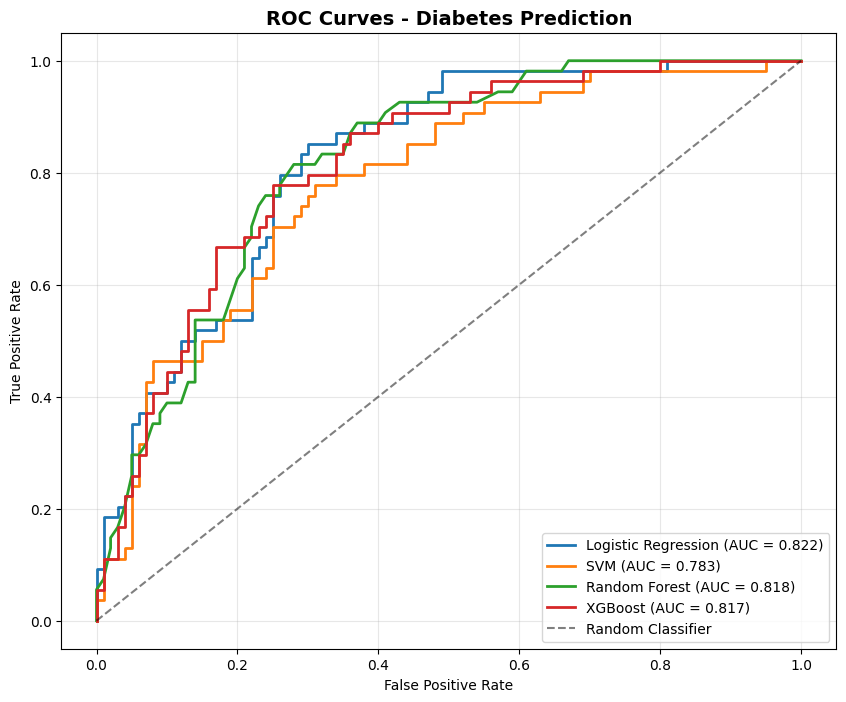

In [30]:
# %% [markdown]
# ## 29. ROC Curves Comparison

# %%
from sklearn.metrics import roc_curve

plt.figure(figsize=(10, 8))

for name, proba in zip(models, probabilities):
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc = roc_auc_score(y_test, proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Diabetes Prediction', fontweight='bold', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

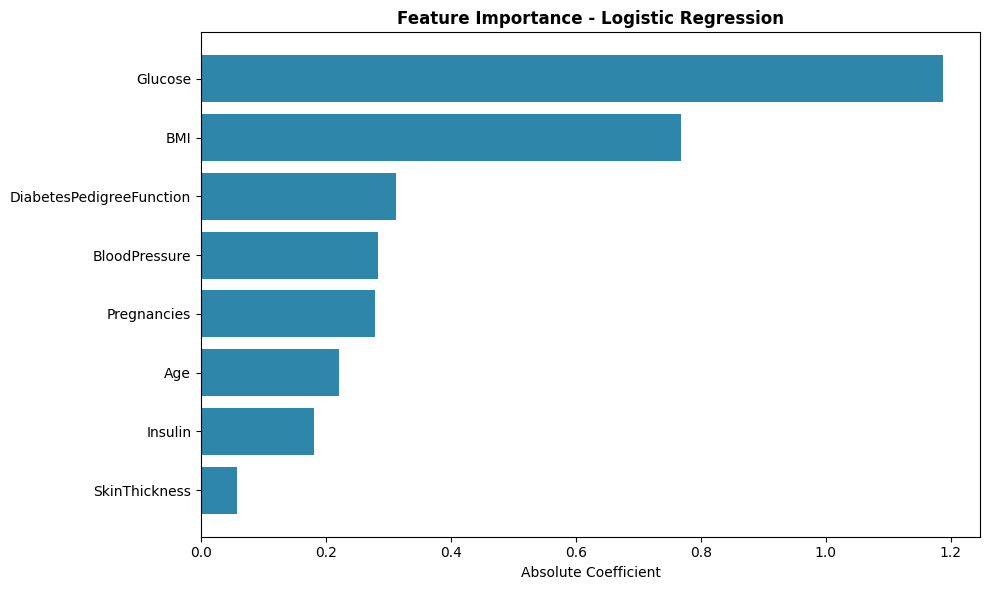

In [31]:
# %% [markdown]
# ## 30. Feature Importance Analysis

# %%
if best_model in ['Random Forest', 'XGBoost']:
    best_model_obj = [rf_model, xgb_model][models.index(best_model)-2]
    importances = best_model_obj.feature_importances_
    
    feat_imp = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    }).sort_values('Importance', ascending=True)
    
    plt.figure(figsize=(10, 8))
    colors = plt.cm.Blues(np.linspace(0.3, 1, len(feat_imp)))
    plt.barh(feat_imp['Feature'], feat_imp['Importance'], color=colors[::-1])
    plt.xlabel('Importance')
    plt.title(f'Feature Importance - {best_model}', fontweight='bold', fontsize=14)
    
    for i, (_, row) in enumerate(feat_imp.iterrows()):
        plt.text(row['Importance'] + 0.005, i, f'{row["Importance"]:.3f}', 
                 va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    print("📊 TOP 5 MOST IMPORTANT FEATURES:")
    for i, row in feat_imp.tail(5).iterrows():
        print(f"   {row['Feature']}: {row['Importance']:.4f}")
else:
    # For Logistic Regression, show coefficients
    coef = np.abs(lr_model.coef_[0])
    coef_df = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': coef
    }).sort_values('Coefficient', ascending=True)
    
    plt.figure(figsize=(10, 6))
    plt.barh(coef_df['Feature'], coef_df['Coefficient'], color='#2E86AB')
    plt.xlabel('Absolute Coefficient')
    plt.title('Feature Importance - Logistic Regression', fontweight='bold')
    plt.tight_layout()
    plt.show()

In [32]:
# %% [markdown]
# ## 31. Save Models for Deployment

# %%
import joblib
from datetime import datetime

# Save best model
best_model_obj = [lr_model, svm_model, rf_model, xgb_model][best_idx]
model_path = f'../models/diabetes_{best_model.lower().replace(" ", "_")}_v1.0.0.pkl'
joblib.dump(best_model_obj, model_path)

# Save scaler and features
joblib.dump(scaler, '../models/diabetes_scaler.pkl')
joblib.dump(X.columns.tolist(), '../models/diabetes_features.pkl')

print(f"✅ Best model saved: {model_path}")
print(f"✅ Scaler saved: ../models/diabetes_scaler.pkl")
print(f"✅ Feature names saved: ../models/diabetes_features.pkl")
print(f"📅 Saved at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Best model saved: ../models/diabetes_logistic_regression_v1.0.0.pkl
✅ Scaler saved: ../models/diabetes_scaler.pkl
✅ Feature names saved: ../models/diabetes_features.pkl
📅 Saved at: 2026-02-25 14:01:57


In [33]:
# %% [markdown]
# ## 32. Model Metadata

# %%
import json

metadata = {
    'model_name': best_model,
    'version': '1.0.0',
    'training_date': datetime.now().isoformat(),
    'dataset': 'Pima Indians Diabetes Database',
    'samples': len(df),
    'features': X.columns.tolist(),
    'metrics': {
        'accuracy': float(results_df.loc[best_idx, 'Accuracy']),
        'precision': float(results_df.loc[best_idx, 'Precision']),
        'recall': float(results_df.loc[best_idx, 'Recall']),
        'f1_score': float(results_df.loc[best_idx, 'F1-Score']),
        'roc_auc': float(results_df.loc[best_idx, 'ROC-AUC'])
    },
    'preprocessing': {
        'scaler': 'StandardScaler',
        'balancing': 'SMOTE',
        'missing_handling': 'Median imputation'
    }
}

with open('../models/diabetes_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("✅ Model metadata saved")

✅ Model metadata saved


In [34]:
# %% [markdown]
# ## 33. Test Single Prediction

# %%
# Take first test sample
sample = X_test_scaled[0].reshape(1, -1)
actual = y_test.iloc[0]
pred = best_model_obj.predict(sample)[0]
proba = best_model_obj.predict_proba(sample)[0]

print("🔍 SINGLE PREDICTION TEST:")
print("="*50)
print(f"Actual:      {'DIABETES' if actual == 1 else 'NO DIABETES'}")
print(f"Predicted:   {'DIABETES' if pred == 1 else 'NO DIABETES'}")
print(f"Probability: No Diabetes: {proba[0]:.3f}, Diabetes: {proba[1]:.3f}")
print(f"Confidence:  {max(proba)*100:.1f}%")
print(f"Risk Level:  {'HIGH' if pred == 1 else 'LOW'}")
print("="*50)

if pred == actual:
    print("✅ Prediction CORRECT")
else:
    print("❌ Prediction INCORRECT")

🔍 SINGLE PREDICTION TEST:
Actual:      NO DIABETES
Predicted:   DIABETES
Probability: No Diabetes: 0.256, Diabetes: 0.744
Confidence:  74.4%
Risk Level:  HIGH
❌ Prediction INCORRECT


In [35]:
# %% [markdown]
# ## 34. Export Results to CSV

# %%
results_df.to_csv('../reports/diabetes_model_comparison.csv', index=False)
print("✅ Results exported to reports/diabetes_model_comparison.csv")

# Display styled table
styled = results_df.style.background_gradient(cmap='Blues', subset=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'])
styled

✅ Results exported to reports/diabetes_model_comparison.csv


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Logistic Regression,0.740300,0.609400,0.722200,0.661000,0.822200
1,SVM,0.714300,0.569400,0.759300,0.650800,0.782800
2,Random Forest,0.746800,0.627100,0.685200,0.654900,0.818000
3,XGBoost,0.740300,0.616700,0.685200,0.649100,0.817000


In [37]:
# %% [markdown]
# ## 35. Pipeline Complete - Final Summary

# %%
import os

# Create reports directory if it doesn't exist
os.makedirs('../reports', exist_ok=True)

# Use ASCII characters instead of box drawing characters
summary = f"""
{'='*70}
              DIABETES PREDICTION - PIPELINE COMPLETE
{'='*70}
  Dataset:        Pima Indians Diabetes
  Patients:       {len(df):,}
  Features:       {len(X.columns)}
  Diabetes cases: {target_dist[1]} ({target_pct[1]:.1f}%)
  Best Model:     {best_model}
  
  PERFORMANCE METRICS:
  {'-'*50}
  F1-Score:       {results_df.loc[best_idx, 'F1-Score']:.4f}
  Accuracy:       {results_df.loc[best_idx, 'Accuracy']:.4f}
  Precision:      {results_df.loc[best_idx, 'Precision']:.4f}
  Recall:         {results_df.loc[best_idx, 'Recall']:.4f}
  ROC-AUC:        {results_df.loc[best_idx, 'ROC-AUC']:.4f}
  
  SAVED FILES:
  {'-'*50}
  Model:          models/diabetes_{best_model.lower().replace(' ', '_')}_v1.0.0.pkl
  Scaler:         models/diabetes_scaler.pkl
  Features:       models/diabetes_features.pkl
  Metadata:       models/diabetes_metadata.json
  Results:        reports/diabetes_model_comparison.csv
  This summary:   reports/diabetes_summary.txt
{'='*70}
"""

print(summary)

# Save with UTF-8 encoding (fixes the error!)
with open('../reports/diabetes_summary.txt', 'w', encoding='utf-8') as f:
    f.write(summary)

print(f"✅ Summary saved to: ../reports/diabetes_summary.txt")

# Verify file was saved
if os.path.exists('../reports/diabetes_summary.txt'):
    size = os.path.getsize('../reports/diabetes_summary.txt') / 1024
    print(f"✅ File size: {size:.1f} KB")


              DIABETES PREDICTION - PIPELINE COMPLETE
  Dataset:        Pima Indians Diabetes
  Patients:       768
  Features:       8
  Diabetes cases: 268 (34.9%)
  Best Model:     Logistic Regression

  PERFORMANCE METRICS:
  --------------------------------------------------
  F1-Score:       0.6610
  Accuracy:       0.7403
  Precision:      0.6094
  Recall:         0.7222
  ROC-AUC:        0.8222

  SAVED FILES:
  --------------------------------------------------
  Model:          models/diabetes_logistic_regression_v1.0.0.pkl
  Scaler:         models/diabetes_scaler.pkl
  Features:       models/diabetes_features.pkl
  Metadata:       models/diabetes_metadata.json
  Results:        reports/diabetes_model_comparison.csv
  This summary:   reports/diabetes_summary.txt

✅ Summary saved to: ../reports/diabetes_summary.txt
✅ File size: 1.0 KB


In [38]:
# %% [markdown]
# ## 36. Ready for Deployment

# %%
print("""
🚀 DEPLOYMENT INSTRUCTIONS:

1. Start Diabetes Prediction API:
   $ uvicorn api.main:app --reload

2. Test API endpoint:
   curl -X POST http://localhost:8000/predict/diabetes \\
        -H "Content-Type: application/json" \\
        -d '{
            "pregnancies": 2,
            "glucose": 120,
            "bp": 70,
            "skin_thickness": 20,
            "insulin": 80,
            "bmi": 25.1,
            "dpf": 0.5,
            "age": 33
        }'

3. Expected response:
   {
     "disease": "Diabetes",
     "prediction": 0,
     "probability": 0.15,
     "risk_level": "Low",
     "confidence": 0.85
   }

🎉 Diabetes prediction model is ready for production!
""")


🚀 DEPLOYMENT INSTRUCTIONS:

1. Start Diabetes Prediction API:
   $ uvicorn api.main:app --reload

2. Test API endpoint:
   curl -X POST http://localhost:8000/predict/diabetes \
        -H "Content-Type: application/json" \
        -d '{
            "pregnancies": 2,
            "glucose": 120,
            "bp": 70,
            "skin_thickness": 20,
            "insulin": 80,
            "bmi": 25.1,
            "dpf": 0.5,
            "age": 33
        }'

3. Expected response:
   {
     "disease": "Diabetes",
     "prediction": 0,
     "probability": 0.15,
     "risk_level": "Low",
     "confidence": 0.85
   }

🎉 Diabetes prediction model is ready for production!

